In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import ConstantKernel as C

from sklearn.model_selection import KFold
import matplotlib.patches as mpatches

## Importing the data

In [34]:
data = pd.read_csv("neonatal_basic_data.csv")
training_set = data[data['death']!=0]
training_labels = training_set['death']
training_data = training_set[['ga', 'bw']]
test_set = data[data['death']==0]
#test_labels = test_set['death']
test_data = test_set[['ga', 'bw']]

### Scaling the data

In [35]:
scaler = StandardScaler()
training_data_stand = scaler.fit_transform(training_data)
test_data_stand = scaler.fit_transform(test_data)

minmaxscaler = MinMaxScaler()
training_data_minmax = minmaxscaler.fit_transform(training_data)
test_data_minmax = minmaxscaler.fit_transform(test_data)

## Visualization of the class distribution

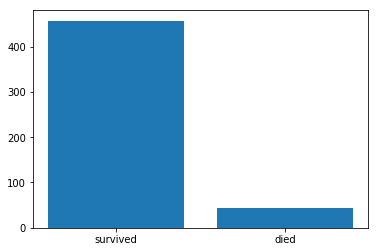

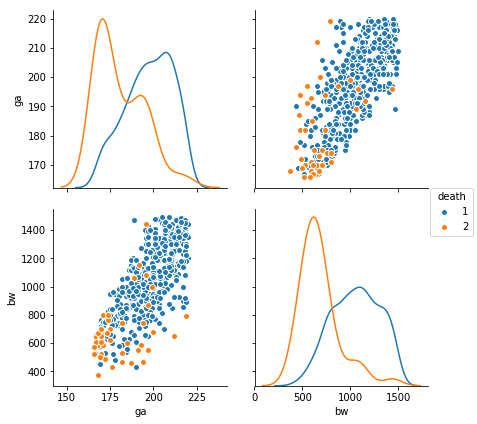

In [36]:
labels = training_labels.as_matrix()
classes, distribution = np.unique(labels, return_counts=True)
plt.bar(classes, distribution)
plt.xticks(classes, ["survived", "died"])
plt.show()

sns.pairplot(training_set[['ga', 'bw', 'death']]
             , hue="death"
             , vars=['ga', 'bw']
             , diag_kind="kde"
             #, kind="reg"
             , size=3
            )
plt.show()

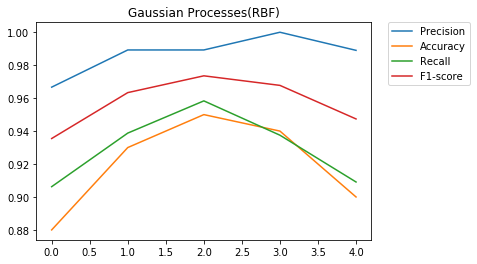

Average on k-fold cross validation
('misclassif error:', 8.0)
('precision:', 0.98683445586671392)
('accuracy:', 0.91999999999999993)
('recall:', 0.92998995052566491)
('f1:', 0.95749799727790652)


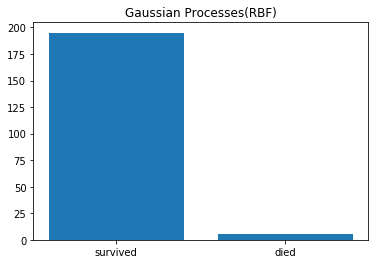

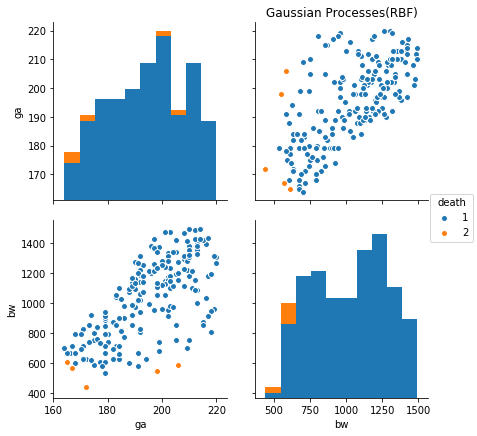

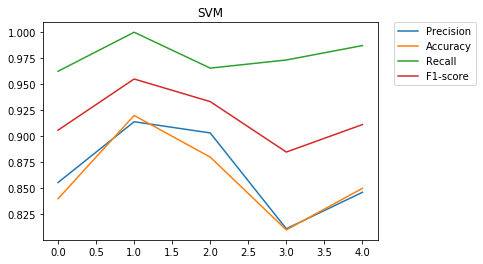

Average on k-fold cross validation
('misclassif error:', 14.0)
('precision:', 0.86600496277915617)
('accuracy:', 0.85999999999999999)
('recall:', 0.97770601237842614)
('f1:', 0.91807259088971416)


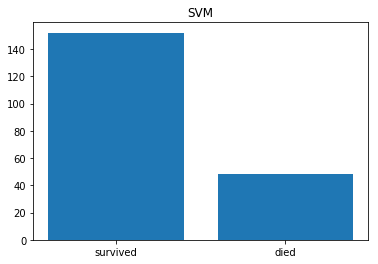

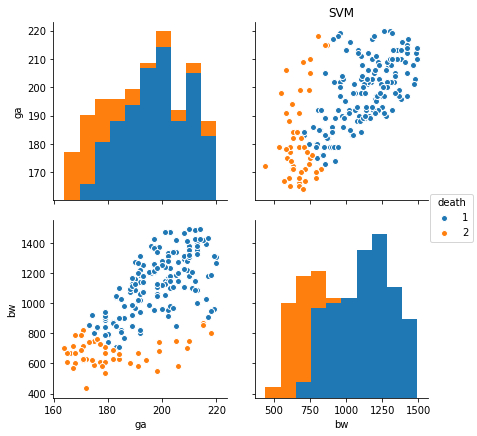

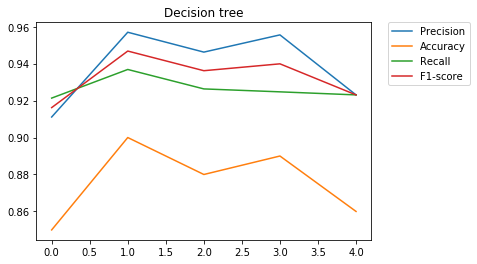

Average on k-fold cross validation
('misclassif error:', 12.4)
('precision:', 0.93859387923904047)
('accuracy:', 0.876)
('recall:', 0.92646286304324121)
('f1:', 0.93242949483642568)


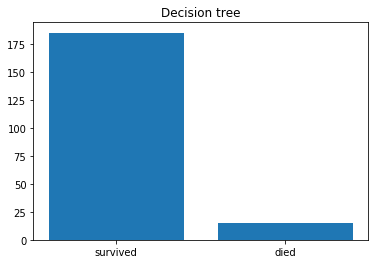

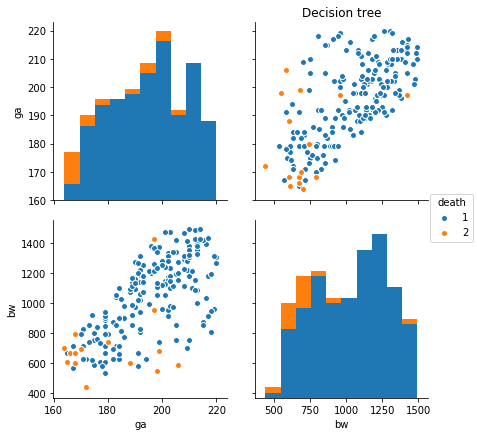

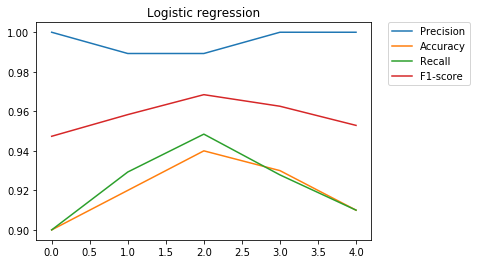

Average on k-fold cross validation
('misclassif error:', 8.0)
('precision:', 0.99569892473118282)
('accuracy:', 0.91999999999999993)
('recall:', 0.92311631781734893)
('f1:', 0.95791384661783252)


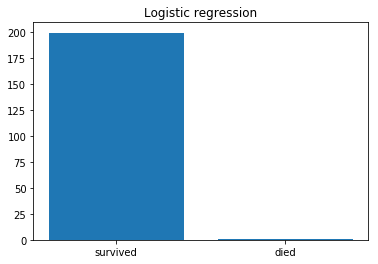

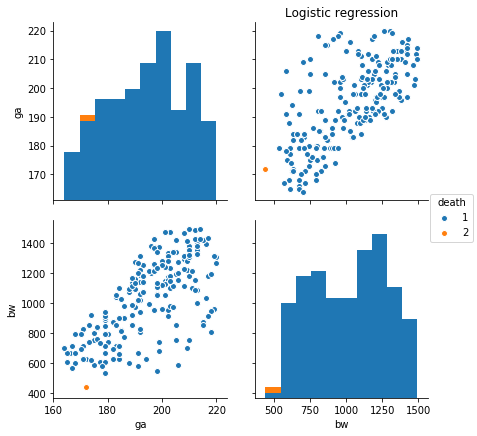

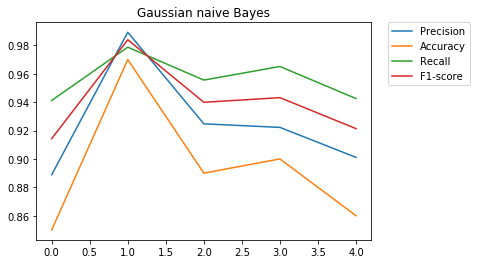

Average on k-fold cross validation
('misclassif error:', 10.6)
('precision:', 0.92523770136673367)
('accuracy:', 0.89399999999999991)
('recall:', 0.95662008902021223)
('f1:', 0.94053275534162495)


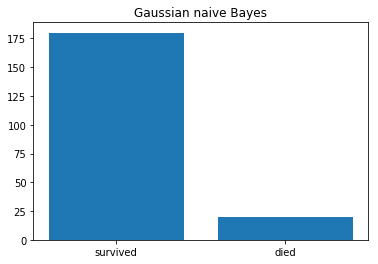

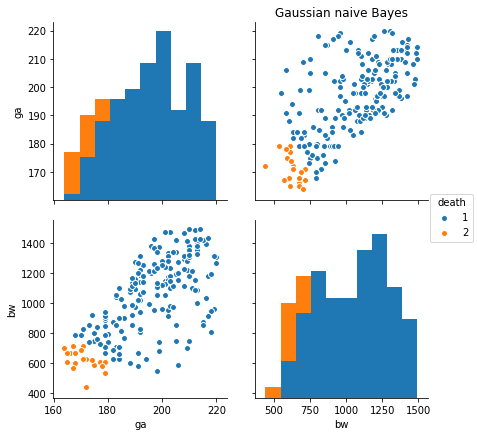

In [37]:
#kernel = 1.0 * C(constant_value=1.0) + 1.0 * RBF(length_scale=1.0)
kernel = 1.0 * RBF(length_scale=1.0)
clfs = [(GaussianProcessClassifier(kernel=kernel, optimizer=None),"Gaussian Processes(RBF)")
        , (svm.SVC(class_weight='balanced', kernel='rbf'),"SVM")
        , (DecisionTreeClassifier(),"Decision tree")
        , (LogisticRegression(),"Logistic regression")
        , (GaussianNB(),"Gaussian naive Bayes")
       ]

for clf, method_name in clfs:
    misclassif_lst = []
    precision_lst = []
    accuracy_lst = []
    recall_lst = []
    f1_lst = []

    kf = KFold(n_splits=5)
    for train_index, test_index in kf.split(training_data_stand):
        X_train, X_test = training_data_stand[train_index], training_data_stand[test_index]
        y_train, y_test = training_labels[train_index], training_labels[test_index]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        misclassif = np.sum(y_pred!=y_test)
        precision = precision_score(y_pred, y_test)
        accuracy = accuracy_score(y_pred, y_test) 
        recall = recall_score(y_pred, y_test)
        f1 = f1_score(y_pred, y_test)

        misclassif_lst.append(misclassif)
        precision_lst.append(precision)
        accuracy_lst.append(accuracy)
        recall_lst.append(recall)

        f1_lst.append(f1)

    plt.plot(range(5), precision_lst, label="Precision")
    plt.plot(range(5), accuracy_lst, label="Accuracy")
    plt.plot(range(5), recall_lst, label="Recall")
    plt.plot(range(5), f1_lst, label="F1-score")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title(method_name)
    plt.show()

    print("Average on k-fold cross validation")
    print("misclassif error:", np.mean(misclassif_lst))
    print("precision:", np.mean(precision_lst))
    print("accuracy:", np.mean(accuracy_lst))
    print("recall:", np.mean(recall_lst))
    print("f1:", np.mean(f1_lst))

    clf.fit(training_data_stand, training_labels)
    p = clf.predict(test_data_stand)

    classes, distribution = np.unique(p, return_counts=True)
    plt.bar(classes, distribution)
    plt.title(method_name)
    plt.xticks(classes, ["survived", "died"])
    plt.show()

    pred = pd.DataFrame(data={#'patientid':test_set['patientid'].as_matrix(), 
                                 'ga':test_set['ga'].as_matrix(), 'bw':test_set['bw'].as_matrix(), 'death':p})

    if method_name=="Gaussian Processes(RBF)":
        gp_pred = pred
    elif method_name=="SVM":
        svm_pred = pred    
    elif method_name=="Decision tree":
        dt_pred = pred
    elif method_name=="Logistic regression":
        lr_pred = pred
    elif method_name=="Gaussian naive Bayes":
        gnb_pred = pred

    sns.pairplot(pred[['ga', 'bw', 'death']]
                 , hue="death"
                 , vars=['ga', 'bw']
                 #, diag_kind="kde"
                 #, kind="reg"
                 , size=3
                )
    plt.title(method_name)
    plt.show()

## Mixing prediction
Final prediction are:
    - Survived: if all the models agree that the patient survived
    - Died: if at least one of the model classify the patient as died

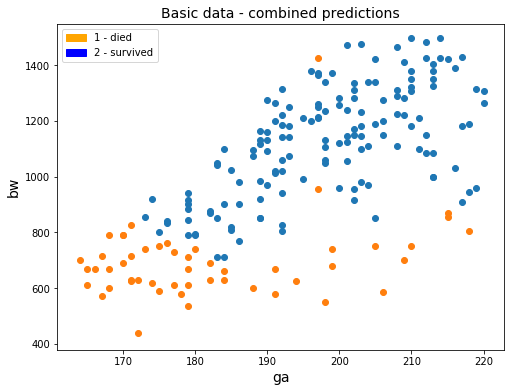

In [39]:
pred = pd.DataFrame(data={'patientid':test_set['patientid'].as_matrix(), 
                             'ga':test_set['ga'].as_matrix(), 'bw':test_set['bw'].as_matrix()
    , 'death_dt':dt_pred['death'], 'death_svm':svm_pred['death'], 'death_lr':lr_pred['death']
    , 'death_gnb':gnb_pred['death'], 'death_gp':gp_pred['death']})

died = pred.loc[(pred['death_lr'] == 2) | (pred['death_dt'] == 2) | (pred['death_svm']==2) | (pred['death_gp'] == 2) | (pred['death_gnb']==2)]
survived = pred.loc[(pred['death_lr'] == 1) & (pred['death_dt'] == 1) & (pred['death_svm']==1) & (pred['death_gp'] == 1) & (pred['death_gnb'] == 1)]
plt.figure(figsize=(8,6))
plt.scatter(survived['ga'], survived['bw'])
plt.scatter(died['ga'], died['bw'])
plt.xlabel("ga", fontsize=14)
plt.ylabel("bw", fontsize=14)

orange_patch = mpatches.Patch(color='orange', label='1 - died')
blue_patch = mpatches.Patch(color='blue', label='2 - survived')
plt.legend(handles=[orange_patch, blue_patch])
plt.title("Basic data - combined predictions", fontsize=14)
plt.show()

## Time-series data classification

In [29]:
ts = pd.read_csv("timeseries.csv", names=['patientid','mean ABP_S','var ABP_S','slope ABP_S','intercept ABP_S','mean ABP_M','var ABP_M','slope ABP_M','intercept ABP_M','mean ABP_D','var ABP_D','slope ABP_D','intercept ABP_D','mean HR_ECG','var HR_ECG','slope HR_ECG','intercept HR_ECG','mean SpO2','var SpO2','slope SpO2','intercept SpO2'])
training_data = ts[ts['patientid'].isin(data[data['death']!=0]['patientid'])]
training_data.drop(['patientid'], axis=1)
test_data = ts[ts['patientid'].isin(data[data['death']==0]['patientid'])]
test_data.drop(['patientid'], axis=1)
ts.shape

(700, 21)

In [30]:
scaler = StandardScaler()
training_data_stand = scaler.fit_transform(training_data)
test_data_stand = scaler.fit_transform(test_data)

minmaxscaler = MinMaxScaler()
training_data_minmax = minmaxscaler.fit_transform(training_data)
test_data_minmax = minmaxscaler.fit_transform(test_data)

## Evaluation of classifier via K-fold cross-validation

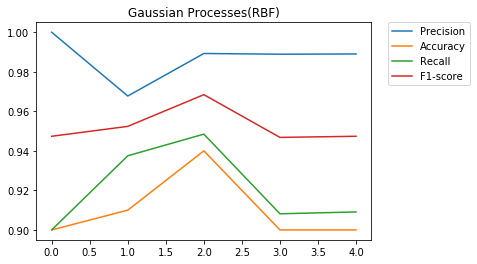

Average on k-fold cross validation
('misclassif error:', 9.0)
('precision:', 0.98697782504234122)
('accuracy:', 0.90999999999999992)
('recall:', 0.92064155652889068)
('f1:', 0.95246947155121853)


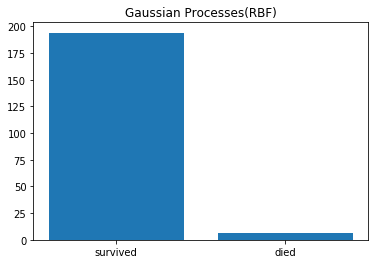

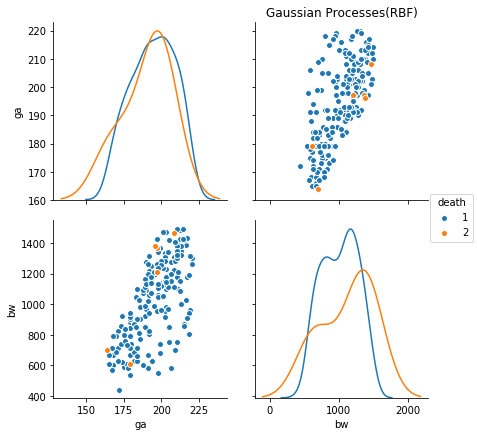

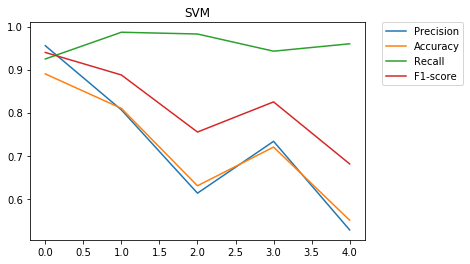

Average on k-fold cross validation
('misclassif error:', 28.0)
('precision:', 0.72714325101421873)
('accuracy:', 0.71999999999999997)
('recall:', 0.95943781032113085)
('f1:', 0.81765652522531218)


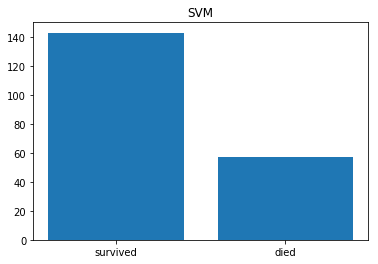

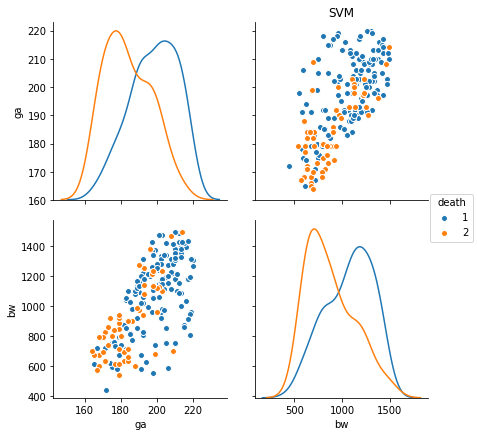

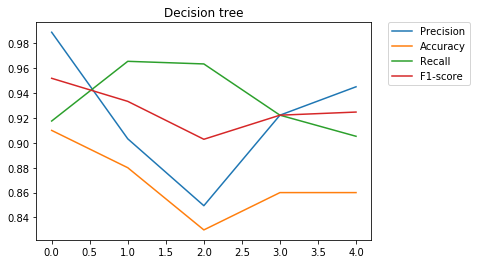

Average on k-fold cross validation
('misclassif error:', 13.199999999999999)
('precision:', 0.92177084564181355)
('accuracy:', 0.86799999999999999)
('recall:', 0.93478860576769751)
('f1:', 0.92700310779248163)


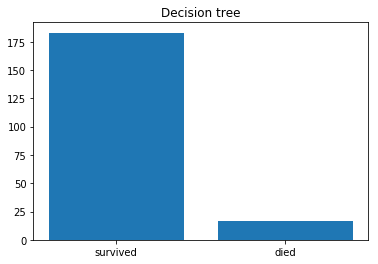

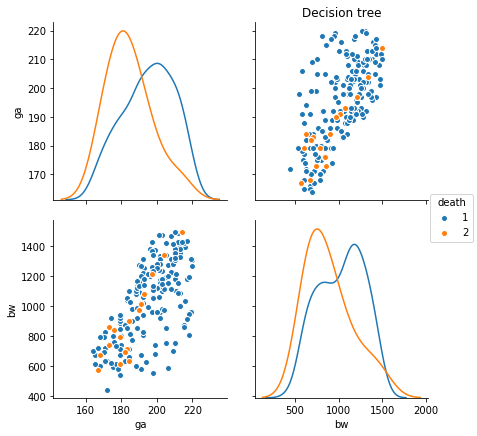

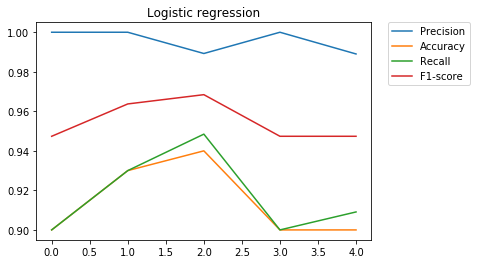

Average on k-fold cross validation
('misclassif error:', 8.5999999999999996)
('precision:', 0.99565166016778917)
('accuracy:', 0.91400000000000003)
('recall:', 0.91750890346766634)
('f1:', 0.9548513771475321)


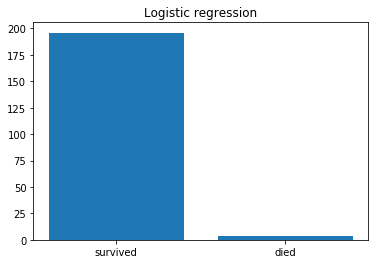

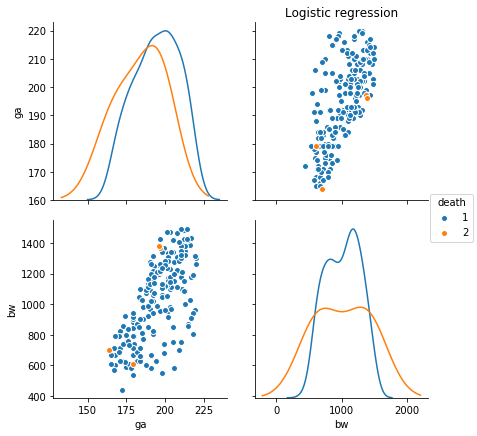

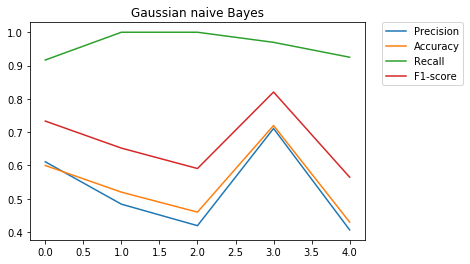

Average on k-fold cross validation
('misclassif error:', 45.399999999999999)
('precision:', 0.52640828705344833)
('accuracy:', 0.54600000000000004)
('recall:', 0.96227272727272728)
('f1:', 0.67236293079638576)


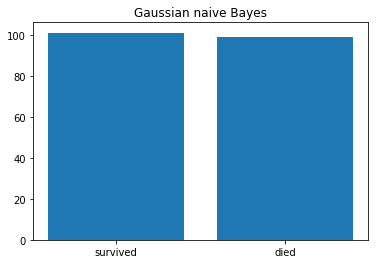

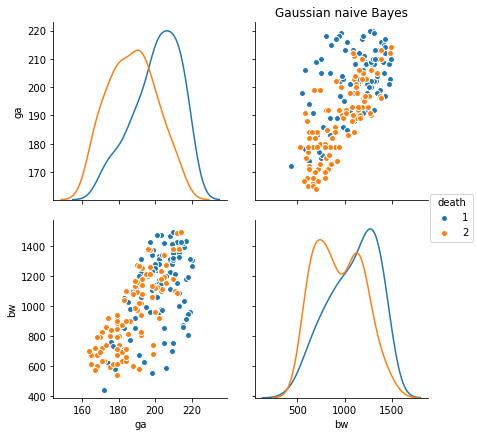

In [31]:
for clf, method_name in clfs:
    misclassif_lst = []
    precision_lst = []
    accuracy_lst = []
    recall_lst = []
    f1_lst = []

    kf = KFold(n_splits=5)
    for train_index, test_index in kf.split(training_data_stand):
        X_train, X_test = training_data_stand[train_index], training_data_stand[test_index]
        y_train, y_test = training_labels[train_index], training_labels[test_index]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        misclassif = np.sum(y_pred!=y_test)
        precision = precision_score(y_pred, y_test)
        accuracy = accuracy_score(y_pred, y_test) 
        recall = recall_score(y_pred, y_test)
        f1 = f1_score(y_pred, y_test)

        misclassif_lst.append(misclassif)
        precision_lst.append(precision)
        accuracy_lst.append(accuracy)
        recall_lst.append(recall)

        f1_lst.append(f1)

    plt.plot(range(5), precision_lst, label="Precision")
    plt.plot(range(5), accuracy_lst, label="Accuracy")
    plt.plot(range(5), recall_lst, label="Recall")
    plt.plot(range(5), f1_lst, label="F1-score")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title(method_name)
    plt.show()

    print("Average on k-fold cross validation")
    print("misclassif error:", np.mean(misclassif_lst))
    print("precision:", np.mean(precision_lst))
    print("accuracy:", np.mean(accuracy_lst))
    print("recall:", np.mean(recall_lst))
    print("f1:", np.mean(f1_lst))

    clf.fit(training_data_stand, training_labels)
    p = clf.predict(test_data_stand)

    classes, distribution = np.unique(p, return_counts=True)
    plt.bar(classes, distribution)
    plt.title(method_name)
    plt.xticks(classes, ["survived", "died"])
    plt.show()

    pred = pd.DataFrame(data={#'patientid':test_set['patientid'].as_matrix(), 
                                 'ga':test_set['ga'].as_matrix(), 'bw':test_set['bw'].as_matrix(), 'death':p})
    
    if method_name=="Gaussian Processes(RBF)":
        gp_pred = pred
    elif method_name=="SVM":
        svm_pred = pred    
    elif method_name=="Decision tree":
        dt_pred = pred
    elif method_name=="Logistic regression":
        lr_pred = pred
    #elif method_name=="Gaussian naive Bayes":
    #    gnb_pred = pred
    
    sns.pairplot(pred[['ga', 'bw', 'death']]
                 , hue="death"
                 , vars=['ga', 'bw']
                 , diag_kind="kde"
                 #, kind="reg"
                 , size=3
                )
    plt.title(method_name)
    plt.show()

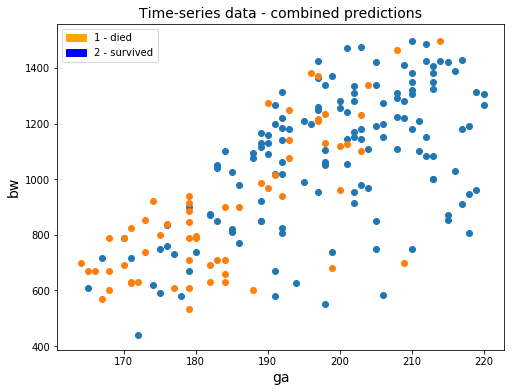

In [33]:
pred = pd.DataFrame(data={'patientid':test_set['patientid'].as_matrix(), 
                             'ga':test_set['ga'].as_matrix(), 'bw':test_set['bw'].as_matrix()
    , 'death_dt':dt_pred['death'], 'death_svm':svm_pred['death']
    , 'death_lr':lr_pred['death'], 'death_gp':gp_pred['death']})

died = pred.loc[(pred['death_dt'] == 2) | (pred['death_svm']==2) | (pred['death_gp'] == 2) | (pred['death_lr']==2)]
survived = pred.loc[(pred['death_dt'] == 1) & (pred['death_svm']==1) & (pred['death_gp'] == 1) & (pred['death_lr'] == 1)]
plt.figure(figsize=(8,6))
plt.scatter(survived['ga'], survived['bw'])
plt.scatter(died['ga'], died['bw'])
plt.xlabel("ga", fontsize=14)
plt.ylabel("bw", fontsize=14)

orange_patch = mpatches.Patch(color='orange', label='1 - died')
blue_patch = mpatches.Patch(color='blue', label='2 - survived')
plt.legend(handles=[orange_patch, blue_patch])
plt.title("Time-series data - combined predictions", fontsize=14)
plt.show()

# Combining time-series with basic data

In [40]:
# ts, data
fulldata = data.merge(ts, on='patientid')
training_set = fulldata[fulldata['death']!=0]
training_labels = training_set['death']
training_data = training_set.drop(['patientid', 'death'], axis=1)
test_set = fulldata[fulldata['death']==0]
test_data = test_set.drop(['patientid', 'death'], axis=1)

In [41]:
scaler = StandardScaler()
training_data_stand = scaler.fit_transform(training_data)
test_data_stand = scaler.fit_transform(test_data)

minmaxscaler = MinMaxScaler()
training_data_minmax = minmaxscaler.fit_transform(training_data)
test_data_minmax = minmaxscaler.fit_transform(test_data)

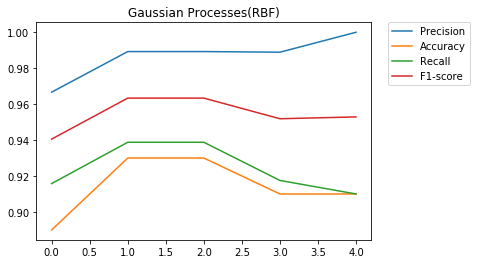

Average on k-fold cross validation
('misclassif error:', 8.5999999999999996)
('precision:', 0.98681003584229399)
('accuracy:', 0.91400000000000003)
('recall:', 0.92417325345764989)
('f1:', 0.95439867002540235)


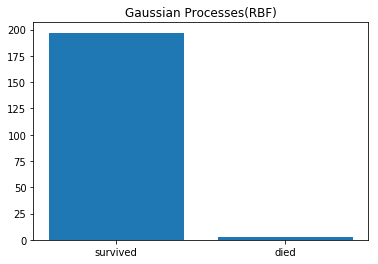

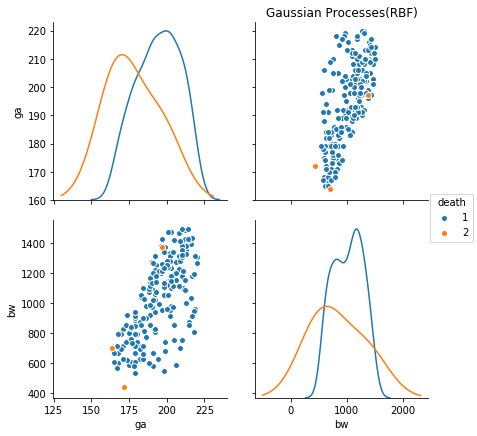

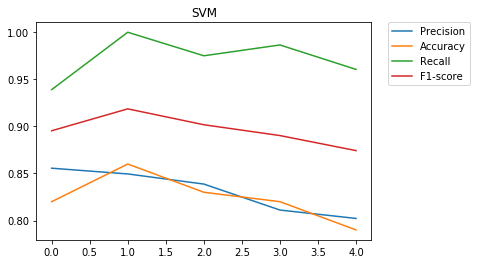

Average on k-fold cross validation
('misclassif error:', 17.600000000000001)
('precision:', 0.83140730237504423)
('accuracy:', 0.82399999999999984)
('recall:', 0.97220743850397251)
('f1:', 0.89603659837266958)


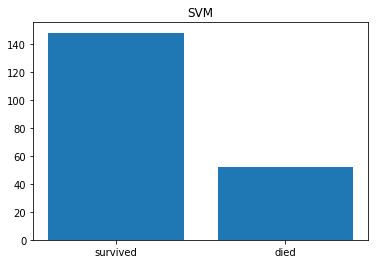

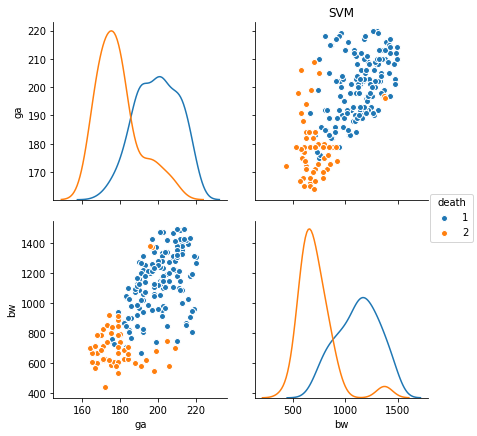

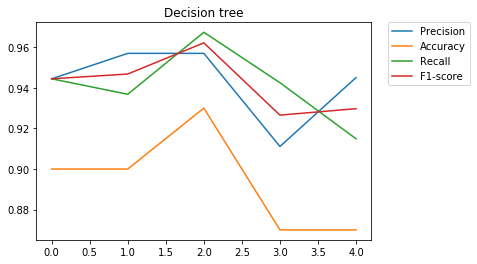

Average on k-fold cross validation
('misclassif error:', 10.6)
('precision:', 0.94291779904683126)
('accuracy:', 0.89399999999999991)
('recall:', 0.94122004134177784)
('f1:', 0.94193970385820369)


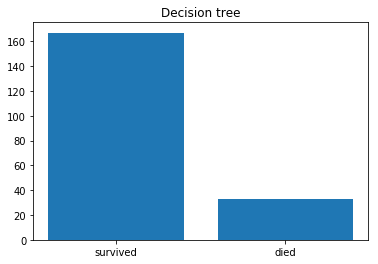

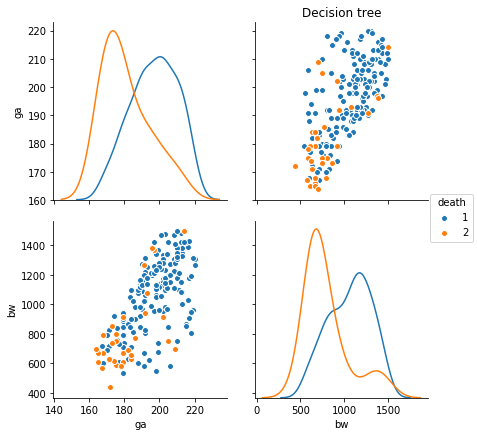

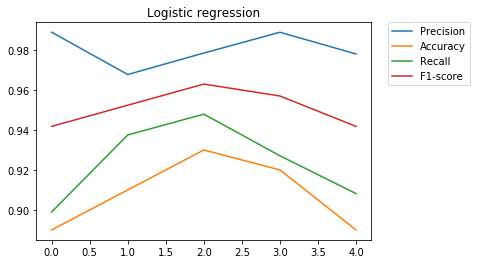

Average on k-fold cross validation
('misclassif error:', 9.1999999999999993)
('precision:', 0.98040726298790815)
('accuracy:', 0.90800000000000003)
('recall:', 0.92393063285920429)
('f1:', 0.95118620925072539)


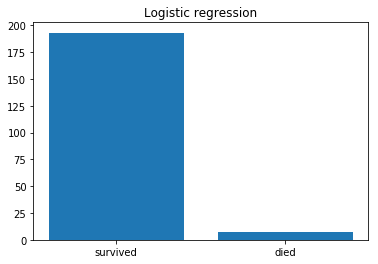

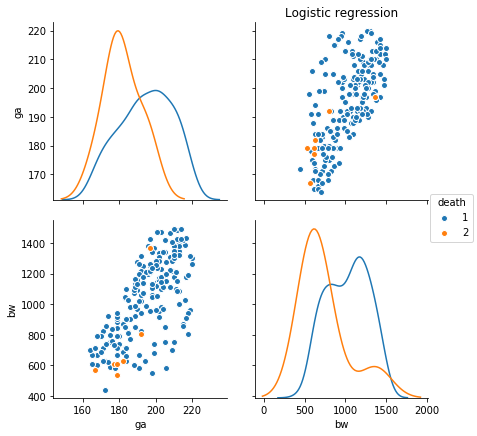

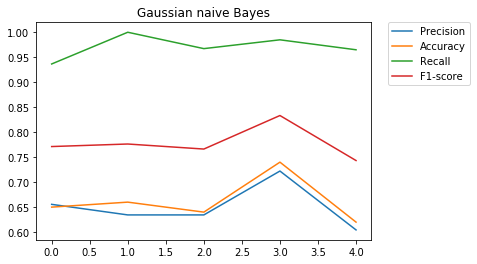

Average on k-fold cross validation
('misclassif error:', 33.799999999999997)
('precision:', 0.65019811729489152)
('accuracy:', 0.66200000000000014)
('recall:', 0.97069636336245479)
('f1:', 0.77807359246987728)


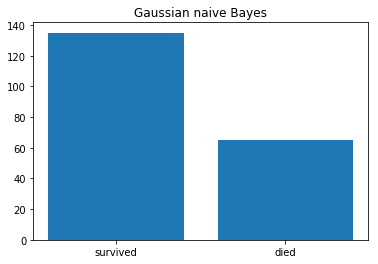

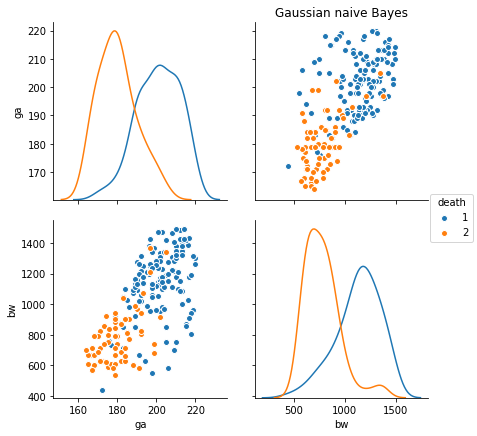

In [42]:
for clf, method_name in clfs:
    misclassif_lst = []
    precision_lst = []
    accuracy_lst = []
    recall_lst = []
    f1_lst = []

    kf = KFold(n_splits=5)
    for train_index, test_index in kf.split(training_data_stand):
        X_train, X_test = training_data_stand[train_index], training_data_stand[test_index]
        y_train, y_test = training_labels[train_index], training_labels[test_index]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        misclassif = np.sum(y_pred!=y_test)
        precision = precision_score(y_pred, y_test)
        accuracy = accuracy_score(y_pred, y_test) 
        recall = recall_score(y_pred, y_test)
        f1 = f1_score(y_pred, y_test)

        misclassif_lst.append(misclassif)
        precision_lst.append(precision)
        accuracy_lst.append(accuracy)
        recall_lst.append(recall)

        f1_lst.append(f1)

    plt.plot(range(5), precision_lst, label="Precision")
    plt.plot(range(5), accuracy_lst, label="Accuracy")
    plt.plot(range(5), recall_lst, label="Recall")
    plt.plot(range(5), f1_lst, label="F1-score")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title(method_name)
    plt.show()

    print("Average on k-fold cross validation")
    print("misclassif error:", np.mean(misclassif_lst))
    print("precision:", np.mean(precision_lst))
    print("accuracy:", np.mean(accuracy_lst))
    print("recall:", np.mean(recall_lst))
    print("f1:", np.mean(f1_lst))

    clf.fit(training_data_stand, training_labels)
    p = clf.predict(test_data_stand)

    classes, distribution = np.unique(p, return_counts=True)
    plt.bar(classes, distribution)
    plt.title(method_name)
    plt.xticks(classes, ["survived", "died"])
    plt.show()

    pred = pd.DataFrame(data={#'patientid':test_set['patientid'].as_matrix(), 
                                 'ga':test_set['ga'].as_matrix(), 'bw':test_set['bw'].as_matrix(), 'death':p})
    
    if method_name=="Gaussian Processes(RBF)":
        gp_pred = pred
    elif method_name=="SVM":
        svm_pred = pred    
    elif method_name=="Decision tree":
        dt_pred = pred
    elif method_name=="Logistic regression":
        lr_pred = pred
    #elif method_name=="Gaussian naive Bayes":
    #    gnb_pred = pred
    
    sns.pairplot(pred[['ga', 'bw', 'death']]
                 , hue="death"
                 , vars=['ga', 'bw']
                 , diag_kind="kde"
                 #, kind="reg"
                 , size=3
                )
    plt.title(method_name)
    plt.show()

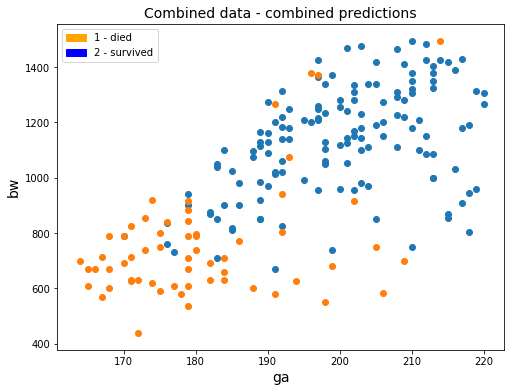

In [44]:
pred = pd.DataFrame(data={'patientid':test_set['patientid'].as_matrix(), 
                             'ga':test_set['ga'].as_matrix(), 'bw':test_set['bw'].as_matrix()
    , 'death_dt':dt_pred['death'], 'death_svm':svm_pred['death']
    , 'death_lr':lr_pred['death'], 'death_gp':gp_pred['death']})

died = pred.loc[(pred['death_dt'] == 2) | (pred['death_svm']==2) | (pred['death_gp'] == 2) | (pred['death_lr']==2)]
survived = pred.loc[(pred['death_dt'] == 1) & (pred['death_svm']==1) & (pred['death_gp'] == 1) & (pred['death_lr'] == 1)]
plt.figure(figsize=(8,6))
plt.scatter(survived['ga'], survived['bw'])
plt.scatter(died['ga'], died['bw'])
plt.xlabel("ga", fontsize=14)
plt.ylabel("bw", fontsize=14)

orange_patch = mpatches.Patch(color='orange', label='1 - died')
blue_patch = mpatches.Patch(color='blue', label='2 - survived')
plt.legend(handles=[orange_patch, blue_patch])
plt.title("Combined data - combined predictions", fontsize=14)
plt.show()